In [83]:
!pip install keras-tuner

In [84]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np

In [85]:
tf.__version__

'2.8.0'

In [86]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [87]:
x_train.shape

(60000, 28, 28)

In [88]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

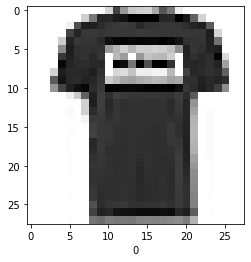

In [89]:
plt.imshow(x_train[1], cmap= 'binary')
plt.xlabel(y_train[1])
plt.show()

In [90]:
def create_model(hp):

    num_hidden_layers = 1
    num_units = 8
    dropout_rate = .1
    learning_rate = .01

    if hp:
        number_hidden_layers = hp.Choice('num_hidden_layers', values=[1, 2, 3])
        num_units = hp.Choice('num_units', values = [8,16,32])
        dropout_rate = hp.Float('dropout_rate', min_value = .1, max_value = .5)
        learning_rate = hp.Float('learning_rate', min_value = .0001,max_value = .01)

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Lambda(lambda x: x/255.))

    for _ in range(0, num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_units, activation = 'relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics = ['accuracy']
    )
    return model

In [91]:
create_model(None).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 lambda_1 (Lambda)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 6280      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [92]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
    def run_trail(self, trail, *args, **kwargs):
        kwargs['batch_size'] = trail.hyperparameters.Int('batch_size', 32, 128, step= 32)
        super(CustomTuner, self).run_trial(trail, *args, **kwargs)


In [93]:
tuner = CustomTuner(
    create_model,
    objective = 'val_accuracy',
    max_trials=3,
    directory = 'logs',
    project_name='fashion_mnist',
    overwrite = True
)


In [94]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [95]:
tuner.search(
    x_train, y_train,
    validation_data = (x_test,y_test),
    epochs = 5, verbose=True
)

INFO:tensorflow:Oracle triggered exit


In [96]:
tuner.results_summary(1)

Results summary
Results in logs/fashion_mnist
Showing 1 best trials
Trial summary
Hyperparameters:
num_hidden_layers: 3
num_units: 32
dropout_rate: 0.12566166246049548
learning_rate: 0.0005984975559836051
Score: 0.8608999848365784


In [97]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [98]:
from gc import callbacks
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test,y_test),
    epochs=20,batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)]
)

Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.3777 - accuracy: 0.8649 - val_loss: 0.3871 - val_accuracy: 0.8626
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3713 - accuracy: 0.8676 - val_loss: 0.3857 - val_accuracy: 0.8624
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3674 - accuracy: 0.8676 - val_loss: 0.3809 - val_accuracy: 0.8657
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3634 - accuracy: 0.8687 - val_loss: 0.3804 - val_accuracy: 0.8640
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3613 - accuracy: 0.8702 - val_loss: 0.3775 - val_accuracy: 0.8643
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3555 - accuracy: 0.8723 - val_loss: 0.3757 - val_accuracy: 0.8659
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3525 - accuracy: 0.8720 - val_loss: 0.3698 - val_accuracy: 0.8676
Epoch 